In [ ]:
import tensorflow as tf
import os
import shutil
import numpy as np
import glob as glob
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/mu2mech_final_data_with_testing.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_90.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_100.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_110.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_120.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_130.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_140.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_150.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_160.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_170.00.png  
  inflating: /content/mu2mech_final_data/Test_images/10time_step/0.485%/output_180.00.png  
  inflating: /content/mu2mech_

In [ ]:
model = load_model("/content/drive/MyDrive/New_models_Mu2Mech/5th_time_step/ConvLSTM/lstm_model_10.hdf5")
layer_name = 'max_pooling2d_2'
encoder = tf.keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)
layer_name = 'conv2d_6'
decoder = tf.keras.Model(inputs=encoder.output,outputs=model.get_layer(layer_name).output)

# ConvLSTM


In [ ]:
# Input for ConvLSTM

compositions = ['0.25%', '0.3%', '0.33%', '0.35%','0.37%', '0.4%', '0.43%', '0.45%', '0.47%', '0.5%']
train_images = []
from tkinter import Tcl
from PIL import Image

for i in range(0,10):
 comp = compositions[i]
 X = glob.glob("/content/mu2mech_final_data/10time_step/"+comp+"/*.png")
 X_sorted = Tcl().call('lsort', '-dict', X)
 print(len(X_sorted))
#  train_images = []

 for i,path in enumerate(X_sorted[1:]):
  image = cv2.imread(X_sorted[i])
  img = np.array(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype("float32") / 255
  train_images.append(img)

print(len(train_images))
# 1k images

# Converting to a numpy array
train_images = np.array(train_images)
print(train_images.shape)

X_train = train_images
print(X_train.shape)

# Inputs for the ConvLSTM
encoded_images = encoder.predict(X_train)

print(encoded_images.shape)

convlstm_input = []

for i in range(0,9960):
  temp = encoded_images[i:i+40,...]
  convlstm_input.append(temp)

convlstm_input = np.array(convlstm_input)

# Input is a 5D array - (samples, time_steps, H,W,filters)
convlstm_input.shape

# Inputs for the ConvLSTM model
X = convlstm_input

# Y will be the current 40 frames + 1st image
Y = encoded_images[40:,...]

print(X.shape)
print(Y.shape)



1001
1001
1001
1001
1001
1001
1001
1001
1001
1001
10000
(10000, 128, 128, 3)
(10000, 128, 128, 3)
313/313 [==============================] - 12s 7ms/step
(10000, 16, 16, 4)
(9960, 40, 16, 16, 4)
(9960, 16, 16, 4)


In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# Construct the input layer with no definite frame size.
inp = tf.keras.layers.Input(shape=(None, *X.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.

x = tf.keras.layers.ConvLSTM2D(
    filters=16,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.ConvLSTM2D(
#     filters=8,
#     kernel_size=(3,3),
#     padding="same",
#     return_sequences=True,
#     activation="tanh",
# )(x)

x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ConvLSTM2D(
    filters=8,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="tanh",
)(x)

x = tf.keras.layers.Conv2D(
     filters=4, kernel_size=(3, 3), activation="relu", padding="same"
)(x)

# Next, we will build the complete model and compile it.
lstm_model = tf.keras.models.Model(inp, x)


In [ ]:

lstm_model.compile(
    loss='mse', optimizer=tf.keras.optimizers.Adam(),metrics=['accuracy']
)
lstm_model.summary()

# Define some callbacks to improve training.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 16, 16, 4)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 16, 16, 16)  32064     
                                                                 
 batch_normalization (BatchN  (None, None, 16, 16, 16)  64       
 ormalization)                                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 16, 16, 8)         800       
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 4)         292       
                                                                 
Total params: 33,220
Trainable params: 33,188
Non-trainable

In [ ]:

# Define modifiable training hyperparameters.
epochs = 50
batch_size = 8

checkpoint_filepath = '/content/drive/MyDrive/New_models_Mu2Mech/10th_time_step/ConvLSTM/lstm_model_10.hdf5'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Splitting into train and validation
size = int(0.8*len(X))

#Training set
X_train = X[:size,...]
# Y = np.expand_dims(Y, axis=1)
y_train = Y[:size,...]

# X_val will be the images
X_val = X[size:,...]
# Y will be current training image + 1
y_val = Y[size:,...]

print(X_val.shape)
print(y_val.shape)
print(X_train.shape)
print(y_train.shape)

(1992, 40, 16, 16, 4)
(1992, 16, 16, 4)
(7968, 40, 16, 16, 4)
(7968, 16, 16, 4)


In [ ]:

# Fit the model to the training data.
lstm_model.fit(
    X_train[0:6000],
    y_train[0:6000],
    batch_size=8,
    epochs=epochs,
    validation_data = (X_val,y_val),
    callbacks=[early_stopping, reduce_lr, model_checkpoint_callback],
)


Epoch 1/50
750/750 [==============================] - 149s 187ms/step - loss: 0.0101 - accuracy: 0.8734 - val_loss: 0.0023 - val_accuracy: 0.9241 - lr: 0.0010
Epoch 2/50
750/750 [==============================] - 138s 183ms/step - loss: 7.9142e-04 - accuracy: 0.9407 - val_loss: 0.0011 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 3/50
750/750 [==============================] - 138s 184ms/step - loss: 5.1805e-04 - accuracy: 0.9549 - val_loss: 7.4811e-04 - val_accuracy: 0.9614 - lr: 0.0010
Epoch 4/50
750/750 [==============================] - 138s 184ms/step - loss: 3.9425e-04 - accuracy: 0.9622 - val_loss: 4.5881e-04 - val_accuracy: 0.9713 - lr: 0.0010
Epoch 5/50
750/750 [==============================] - 137s 182ms/step - loss: 3.4102e-04 - accuracy: 0.9657 - val_loss: 6.1296e-04 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 6/50
750/750 [==============================] - 138s 184ms/step - loss: 2.8964e-04 - accuracy: 0.9686 - val_loss: 3.4033e-04 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 7/50

In [ ]:
preds = lstm_model.predict(X_val)

63/63 [==============================] - 4s 57ms/step


In [ ]:
predicted_img = decoder.predict(preds)

63/63 [==============================] - 1s 12ms/step


In [ ]:
lstm_model = load_model('/content/drive/MyDrive/New_models_Mu2Mech/10th_time_step/ConvLSTM/lstm_model_10.hdf5')

In [ ]:
# Take one composition for testing
test_images = []
from tkinter import Tcl
from PIL import Image

X = glob.glob("/content/mu2mech_final_data/10time_step/0.5%" +"/*.png")
X_sorted = Tcl().call('lsort', '-dict', X)
print(len(X_sorted))

for i,path in enumerate(X_sorted[1:]):
  image = cv2.imread(X_sorted[i])
  img = np.array(image)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype("float32") / 255
  test_images.append(img)

# Converting to a numpy array
test_images = np.array(test_images)
print(test_images.shape)


1001
(1000, 128, 128, 3)


In [ ]:
X_test = test_images
print(X_test.shape)

#Make a separate Y_val for comparing the predicted images
Y_test = test_images[40:]

encoded_images = encoder.predict(X_test)

print(encoded_images.shape)

convlstm_input = []

for i in range(0,960):
  temp = encoded_images[i:i+40,...]
  convlstm_input.append(temp)

convlstm_input = np.array(convlstm_input)

# Input is a 5D array - (samples, time_steps, H,W,filters)
convlstm_input.shape

# Inputs for the ConvLSTM model
X = convlstm_input

print(X.shape)

preds = lstm_model.predict(X)
predictions = decoder.predict(preds)


(1000, 128, 128, 3)
32/32 [==============================] - 0s 12ms/step
(1000, 16, 16, 4)
(960, 40, 16, 16, 4)
30/30 [==============================] - 1s 8ms/step


In [ ]:
imgs = []

def encoder_input(X_test):

  # 1. Encode the images .
  encoded_images = encoder.predict(X_test)
  # Shape - (None, 16, 16, 4)
  convlstm_input = []

  for i in range(0,960):
    temp = encoded_images[i:i+40,...]
    convlstm_input.append(temp)

  convlstm_input = np.array(convlstm_input)
  return convlstm_input

def predict_frames(convlstm_input, idx, frames):
  imgs=[]
  predictions = []
  current_batch = convlstm_input[idx]
  current_batch = current_batch.reshape(1,40, 16, 16, 4)
  for i in range(frames):
     preds = lstm_model.predict(current_batch)[0]
     current_pred = preds
     predictions.append(current_pred)
    #  imgs.append(current_pred)
     print(current_batch.shape)
    #  current_pred = current_pred[np.newaxis,np.newaxis, ...]
     current_pred = np.expand_dims(current_pred,axis=0)
     current_pred = np.expand_dims(current_pred,axis=0)
    #  current_batch = np.append(current_batch[:,1:,...], , axis=1)
     current_batch = np.hstack((current_batch[:, 1:, ...], current_pred))
     imgs.append(current_batch)
     print(current_batch.shape)
  predictions = np.array(predictions)
  return predictions

In [ ]:
inputs = encoder_input(X_test)
preds = predict_frames(inputs, 1, 10)
outputs = decoder.predict(preds)

1/1 [==============================] - 0s 79ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 80ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 78ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 82ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 86ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 80ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 80ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 85ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 95ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 96ms/step
(1, 40, 16, 16, 4)
(1, 40, 16, 16, 4)
1/1 [==============================] - 0s 28ms/step


In [ ]:
imgs = np.squeeze(imgs)
imgs.shape
imgs_dec = decoder.predict(imgs[0])

IndexError: ignored

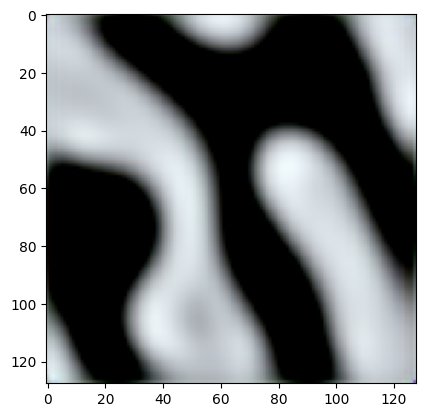

In [ ]:
plt.imshow(imgs_dec[-1])

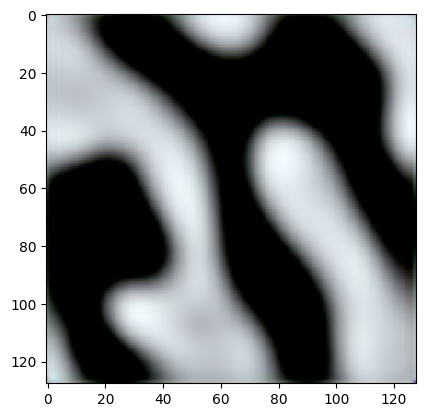

In [ ]:
plt.imshow(outputs[3])

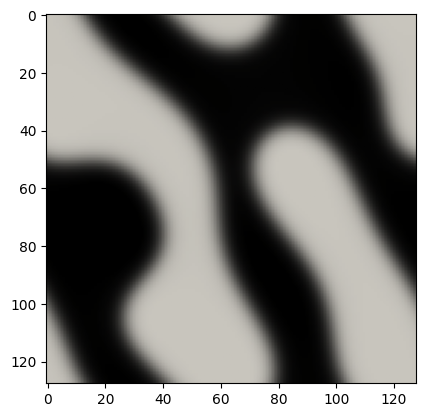

In [ ]:
plt.imshow(Y_test[6])

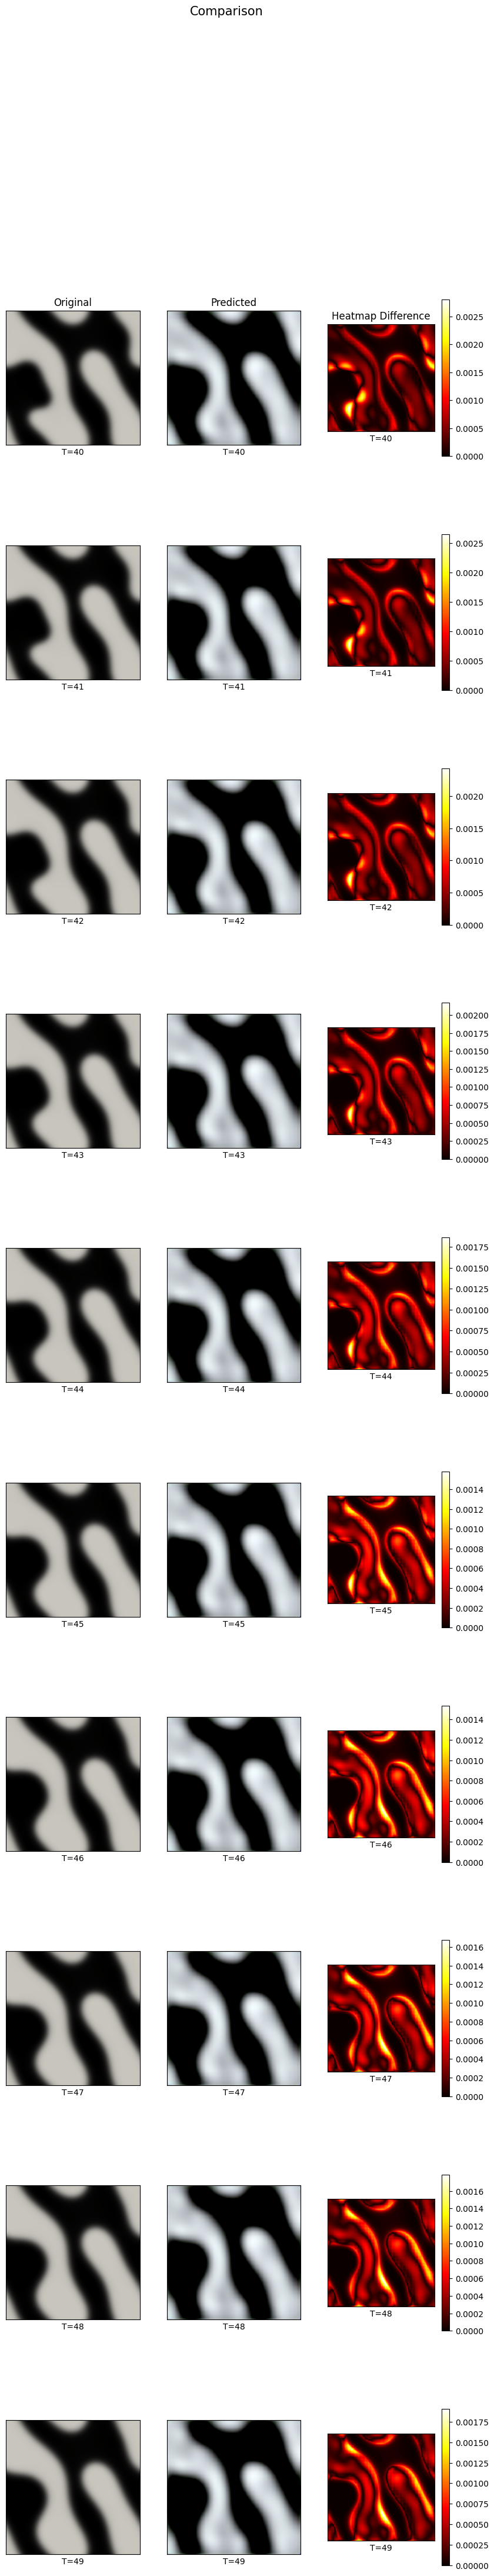

In [ ]:
predicted_imgs = []
heatmaps = []
original_imgs = []
for i in range(0,10):
  original_imgs.append(Y_test[i+1])
  predicted_imgs.append(outputs[i])

  # Convert the NumPy arrays to TensorFlow tensors
  image1 = tf.convert_to_tensor(Y_test[i], dtype=tf.float32)
  image2 = tf.convert_to_tensor(outputs[i], dtype=tf.float32)

  # Preprocess the images
  image1 = tf.image.resize(image1, (256, 256)) / 255.0
  image2 = tf.image.resize(image2, (256, 256)) / 255.0

  # Calculate the absolute difference between the two images
  difference = tf.abs(image1 - image2)

  # Convert the difference tensor to grayscale
  difference_gray = tf.image.rgb_to_grayscale(difference)

  # Reshape the grayscale tensor to a 2D heatmap
  heatmap = tf.reshape(difference_gray, (256,256))
  heatmaps.append(heatmap)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec


# Create a grid of subplots
fig, axs = plt.subplots(10,3,figsize=(10,50))

for ax in axs.flat:
    ax.label_outer()
# Display the images on the grid

for i in range(0,10):
  for j in range(0,3):
    if j==0 :
      h=axs[i,0].imshow(original_imgs[i])
      axs[i,j].set_xticks([])
      axs[i,j].set_yticks([])

    elif j==1 :
      h=axs[i,1].imshow(predicted_imgs[i])
      axs[i,j].set_xticks([])
      axs[i,j].set_yticks([])
    else:
      h = axs[i,2].imshow(heatmaps[i], cmap='hot', interpolation='nearest')
      fig.colorbar(h, ax=axs[i,2])
      axs[i,j].set_xticks([])
      axs[i,j].set_yticks([])
    axs[i,j].set_xlabel(f"T={40+i}")

# Optional: Adjust spacing and remove axis labels
plt.subplots_adjust(hspace=0.5)



# axs[0,0].set_xlabel('T=10')
# axs[1,0].set_xlabel('T=30')
# axs[2,0].set_xlabel('T=60')
# cbar = fig.colorbar(h, ax=axes[i,2])


fig.suptitle("Comparison", fontsize=15)
axs[0,0].title.set_text('Original')
axs[0,1].title.set_text('Predicted')
axs[0,2].title.set_text('Heatmap Difference')


plt.show()